In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc
import time
import pandas as pd
import cx_Oracle
import datetime as dt
from datetime import timedelta,datetime
from IPython import display
import math

font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font',family=font_name)
plt.rcParams['axes.unicode_minus'] = False

In [26]:
con = cx_Oracle.connect('bike/12345@192.168.0.78:1521/xe')
cur = con.cursor()

### 일주일치 날짜 가져오기

In [27]:
def week_col(time):
    start=time-timedelta(days=int(time.weekday()))
    week=pd.date_range(start,periods=7)
    return week.astype(str).to_list()

In [28]:
a = cur.execute("""select max(riding_dt) from riding """).fetchall()[0][0]

In [29]:
week_col(a)

['2023-01-30',
 '2023-01-31',
 '2023-02-01',
 '2023-02-02',
 '2023-02-03',
 '2023-02-04',
 '2023-02-05']

## 주간 데이터

### 내 데이터

#### 칼로리분석

In [30]:
cur.execute("""select m.id as id,r.riding_dt as riding_dt, round(2.3*m.weight*(r.riding_time*0.0667),2) as Kcal 
            from riding r join member m on r.id=m.id""")

columns = ['id','riding_dt','calorie']
calorie_data = pd.DataFrame(cur,columns = columns)

#calorie_data['id']

In [31]:
def plt_Kcal_update(ax,mem_id):
    cur.execute("select * from riding where id = :mem_id order by riding_dt",mem_id)
    
    time=week_col(pd.to_datetime(a))
    
    columns = ['id','distance','calorie','riding_time','riding_dt']
    riding_data = pd.DataFrame(cur,columns=columns)
    riding_data['riding_dt']=riding_data['riding_dt'].astype(str)
    riding_data= riding_data[riding_data['riding_dt'].isin(time)]
    
    df2=pd.DataFrame(time,columns=['riding_dt'])
    

    riding_data['calorie'] = calorie_data['calorie']
    riding_data= riding_data[riding_data['riding_dt'].isin(week_col(a))]
    
    ax.plot(riding_data['riding_dt'],riding_data['calorie'], 'ro--')
    b=pd.merge(riding_data,df2,on='riding_dt', how='outer')
    

    hdisplay.update(fig)
#     return b[['riding_dt','calorie']]
#     return riding_data

In [32]:
#plt_cal_update(ax,'1') #mem_no가 1인 유저의 칼로리 데이터

### 평균 데이터

#### 칼로리분석

In [33]:
def plt_Kcal_avg_update(ax):
    cur.execute("""select r.riding_dt as riding_dt, round(sum(2.3*m.weight*(r.riding_time*0.0667)),2) as sum_Kcal,
                       round(sum(2.3*m.weight*(r.riding_time*0.0667))/ count(distinct(m.id)),2) as avg_Kcal
                       from riding r join member m on r.id=m.id
                       group by r.riding_dt
                       order by r.riding_dt
                        """)
    
    time=week_col(pd.to_datetime(a))

    columns = ['riding_dt','sum_calorie','avg_calorie']
    calorie_avg_data = pd.DataFrame(cur,columns = columns)
    calorie_avg_data['riding_dt']=calorie_avg_data['riding_dt'].astype(str)
    calorie_avg_data= calorie_avg_data[calorie_avg_data['riding_dt'].isin(time)]
    #calorie_avg_data['avg_calorie'] = round(calorie_avg_data['avg_calorie'],2)
    
    df2=pd.DataFrame(time,columns=['riding_dt'])
    b=pd.merge(calorie_avg_data,df2,on='riding_dt', how='outer')
    
    ax.plot(time,b['avg_calorie'], 'yo-')

    hdisplay.update(fig)

In [34]:
#calorie_avg_data

### 상위10%

#### 칼로리분석

In [35]:
def plt_Kcal_avg_update_10(ax):

    cur.execute("""select r.riding_dt as riding_dt, 
       round(sum(2.3*m.weight*(r.riding_time*0.0667))/(select ceil(count(distinct(m.id))*0.1) from riding),2) as avg_Kcal 
       from riding r join member m on r.id=m.id 
       where m.id in (select id from 
       (select sum(2.3*m.weight*(r.riding_time*0.0667)) as avg_sum, m.id 
        from riding r join member m on r.id=m.id 
        where r.riding_dt 
        between :start_day and :end_day group by m.id order by avg_sum desc) 
       where rownum <= (select ceil(count(distinct(id))*0.1) from riding)) 
       group by r.riding_dt 
       order by r.riding_dt""",(week_col(a)[0],week_col(a)[6]))
    
    time=week_col(pd.to_datetime(a))

    columns = ['riding_dt','avg_Kcal']
    Kcal_10_data = pd.DataFrame(cur,columns = columns)
    
    Kcal_10_data['riding_dt']=Kcal_10_data['riding_dt'].astype(str)
    Kcal_10_data= Kcal_10_data[Kcal_10_data['riding_dt'].isin(time)]
    
    df2=pd.DataFrame(time,columns=['riding_dt'])
    b=pd.merge(Kcal_10_data,df2,on='riding_dt', how='outer')

    ax.plot(time,b['avg_Kcal'], 'b*-')
    
    hdisplay.update(fig)

### 실시간그래프

##### yellow => 평균데이터 red => 나의데이터 blue => 상위10% 데이터

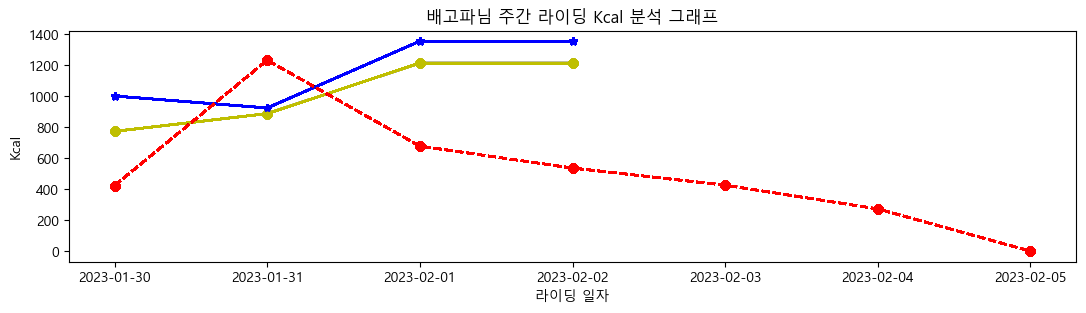

KeyboardInterrupt: 

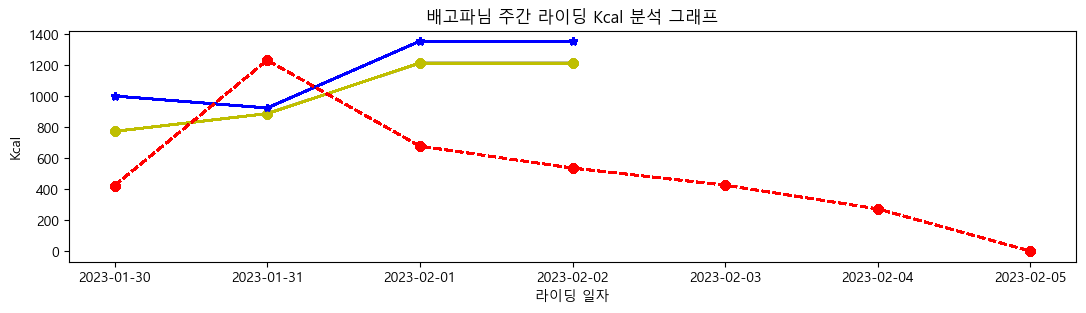

In [40]:
import matplotlib.pyplot as plt
from matplotlib import dates

fig,ax = plt.subplots(1,1)
hdisplay = display.display("", display_id=True)

plt.xticks()

plt.title(' 배고파님 주간 라이딩 Kcal 분석 그래프 ')
plt.rcParams['figure.figsize'] = (13,3)

ax.set_xlabel('라이딩 일자')
ax.set_ylabel('Kcal')

# plt_update(ax)
for f in range(100000):
    plt_Kcal_update(ax,'1')#red
    plt_Kcal_avg_update(ax)#yellow
    plt_Kcal_avg_update_10(ax)#blue
        
    time.sleep(1)

plt.close()